<a href="https://colab.research.google.com/github/rubanzasilva/Linear_model_and_nn_from_scratch/blob/main/Linear_model_and_nn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
#This imports and sets up everything you will need for this notebook
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *
import numpy as np

matplotlib.rc('image', cmap='Greys')

In [ ]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [ ]:
creds = '{"username":"rubanzasilva","key":"a813913345e829b9b4019a3267ede370"}'

In [ ]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
path = Path('titanic')

In [ ]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 2.61MB/s]

In [ ]:
path

Path('titanic')

In [ ]:
path.ls()

(#3) [Path('titanic/gender_submission.csv'),Path('titanic/train.csv'),Path('titanic/test.csv')]

Cleaning the data

In [ ]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


From our previous lessons, we know that we need to multiply each value for every column by some coefficients. But when we look at our data, we see that we have NaN values which is how missing values are represented in pandas.

In some rows for certain columns and we definetly cant multiply the coefficients by a missing value.

Lets check how many values are missing in the dataset by using the is_na function which return True (which is treated as 1 when used as a number and viceversa) for NaN values, so we just add them up for each column.


In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NB: By default pandas sum over the column.

We need to replace the missing values with something for example we can most common value etc., which can be defined by the mode function.For some rows there might be more than one common value, so we choose the 1st value at index 0 with iloc[0].

In [ ]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

Now that we have the value for modes for each column,we can replace the missing numbers with an inplace operation using the pandas fillna function

In [ ]:
df.fillna(modes,inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

As we can see there are no missing values left.

We can use another pandas method describe to get a quick summary of all the numeric columns in our dataset.

In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Long tail distributions

We usually have to watch out for long tailed distributions for example fare where most of the values seem to be between 0 -31 but the max value is 512.3292 which means we have a few large ones, this kind of distribution is usually common for fields that contain monetary values.
Lets view this better with a histogram

This can cause problems for our model as when that column is multiplied with coefficients,the few rows with really big results will dominate the result.

The most common way of dealing with this is to take the logarithm, this squishes the large numbers and makes the distribution more reasonable.However the log(0) is infinite and since our model contains values which are 0, we

<Axes: >

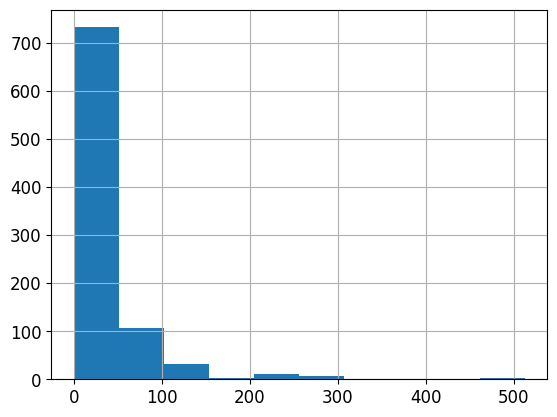

In [ ]:
df['Fare'].hist()

In [ ]:
df['Logfare'] = np.log(df['Fare']+1)

<Axes: >

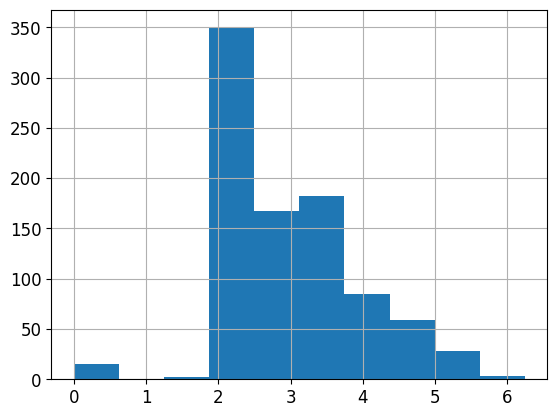

In [ ]:
df['Logfare'].hist()

We should look out for categorical variables such as Pclass which if you notice only has 3 classes which we can confirm by looking at the data dictionary

In [ ]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [ ]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


So remember that we have to multiply our column values by a coefficient but some columns contain strings like male etc and obviously we cant multiply these by numbers.

To get around these we need to replace those with numbers.
We do that by creating new columns containing dummy variables which is a column that contains 1 where a particular value is true and 0 if it isnt for example is_male would be 1 if Sex is male and 0 if is not.We can do this with the pandas get_dummies which also removes the original columns.

We create dummy variables for Pclass as it is categorical, we also add columns for low cardinality columns sex and Embarked. This also adds columns to the end, one for each of the levels for each column while removing the original columns.

Creating dummy variables for Name, Ticket and Cabin would result in too many columns due to the number of levels.

In [ ]:
df = pd.get_dummies(df,columns=["Pclass","Sex","Embarked"])
df.columns

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [ ]:
added_columns = ['Pclass_1', 'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [ ]:
df[added_columns]

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,0,1,0,0,1
1,1,0,0,1,0,1,0,0
2,0,0,1,1,0,0,0,1
3,1,0,0,1,0,0,0,1
4,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,0,0,1
887,1,0,0,1,0,0,0,1
888,0,0,1,1,0,0,0,1
889,1,0,0,0,1,1,0,0


In [ ]:
df.head(2)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Logfare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,0,1,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,0,1,0,1,0,0


Now we create our dependent and independent variables which both need to be tensors.

Our dependent variable is survived

In [ ]:
t_dep = tensor(df.Survived)
t_dep.shape

Our independent variables are all the continuous variables of interest + the added columns

In [ ]:
indep_columns = ['Age', 'SibSp', 'Parch', 'Logfare'] + added_columns

t_indep = tensor(df[indep_columns].values,dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [ ]:
t_indep.shape

torch.Size([891, 12])

Linear Model

Now that we have our dependent and independent columns, the next step is to make predictions and calculate our loss.We can manually create calculate the predcitions and loss for every row of data. The first model we build shall be a simple linear model.

The first thing we need to do is create coefficients for all columns which we multiply each of their rows.
torch.rand produces 12 random numbers between 0 and 1 and subtracting 0.5 from the resulting values results in random coefficient values in the range (-0.5,0.5).


At first, we shall pick a random number and set the manual seed for reproducibility.



In [ ]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Our predictions will be calculated by multplying the coefficients by each row for all our columns and adding them up. Notice how we also dont have a separate constant terms, that is because our dummy variables cover all use cases i.e for sex there is_male and is_female ensuring all data points are well represented.

In [ ]:
indep_coeffs = t_indep * coeffs
indep_coeffs.shape


torch.Size([891, 12])

In [ ]:
indep_coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.0000,   0.4876,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.0000,   0.4876,   0.3136,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.0000,   0.4876,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.0000,   0.4876,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.0000,   0.4876

When we look at our indep_coeffs, we see that the first column has a larger deviation than the rest which will cause some issues when we get the sum of the row values, as the end result will be dominated and influenced by the first column which is age and larger than the rest.

We can ensure all the columns contain values between 0 and 1 by dividing each column by its max():

We seem to drop our columns with strings and a high cardinality.